In [2]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd

sys.path.append('python')
from clusterOutliers import clusterOutliers as coo

In [3]:
def make_sampler(inds=['8462852']): 
    """
    Args:
        inds (Array of strings) - array of indices, as identifying strings, to be pulled from a data frame, 
                                  can be with or without kplr prefix
    Returns:
        Function that will pull the data, indicated by inds, from a dataframe df 
        
    Useful to generate samples across quarters with common sources where data is contained as a 
    Pandas dataframe, with indices set to be identifying labels (i.e. kplr008462852)
    
    To use:
        Define array containing IDs of sources of interest as strings
        Define a sample generator by calling make_sampler(inds=Array of string IDs)
        Generate dataframe by calling new function.

    Example:
    tabby_sample = make_sampler(inds=['8462852'])
    Q4_sample = tabby_sample(Q4.data)
    Q8_sample = tabby_sample(Q8.data)
    etc.
    """
    return lambda df: df[df.index.str.contains('|'.join(inds))]

def import_generator(suffix='_FullSample.csv',
                     filepath="/home/dgiles/Documents/KeplerLCs/output/",
                    fits_files_directory="/home/dgiles/Documents/KeplerLCs/fitsFiles/"):
    """
    Args:
        suffix (str) - the suffix of the file to be imported
        filepath (optional, str) - filepath to the file to be imported
        fits_files_directory (optional, str) - path to the directory containing the fits files
        
    Returns:
        lambda function that with single str input of the prefix, typically a Q#.
    
    Use:
        Enables simpler import of multiple quarters of data contained 
        in the same location with the same suffixes.
    
    Requirements: 
    import sys
    sys.path.append('python')
    from clusterOutliers import clusterOutliers as coo
    """
    return lambda QN: coo(filepath+QN+suffix,fits_files_directory+QN+"fitsfiles")

In [102]:
import_quarter = import_generator(suffix="_FullSample.csv")
qs = ['Q4','Q8','Q11','Q16']
paper_qs = dict(zip(qs,[import_quarter(Q) for Q in qs]))
#Q4p = import_quarter('Q4')

In [460]:
PCA_folder = "/home/dgiles/Documents/KeplerLCs/output/PCA_reductions/"
import_base = import_generator(suffix="_base", filepath=PCA_folder)
base_qs = dict(zip(qs,[import_base(Q) for Q in qs]))

In [82]:
def catalog_sample(source,full_q_df,print_summary=True):
    
    catalog_list = list(np.genfromtxt(source,delimiter=',',dtype=str)[:,0])
    catalog_sampler = make_sampler(catalog_list)
    catalog_df = catalog_sampler(full_q_df)
    outliers = lambda df: df[df.db_out==-1]
    catalog_outliers = outliers(catalog_df)
    q_outliers = outliers(full_q_df)
    
    if print_summary:
        print("""
The {} objects in the catalog comprise {:.2f}% of the {} objects in the quarter.
{} ({:.2f}%) of the catalog objects are outliers, comprising ({:.2f}%) of the {} total outliers in this quarter.
""".format(len(catalog_df), 100*len(catalog_df)/len(full_q_df), len(full_q_df),
           len(catalog_outliers), 100*len(catalog_outliers)/len(catalog_df),
           100*len(catalog_outliers)/len(q_outliers),len(q_outliers)
          ))
            
    return catalog_df
              
kois_full = catalog_sample('list_koi_full.txt',Q4p.data)


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1243 (18.13%) of the catalog objects are outliers, comprising (25.54%) of the 4866 total outliers in this quarter.



In [85]:
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Q4p.data)


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
94 (6.72%) of the catalog objects are outliers, comprising (1.93%) of the 4866 total outliers in this quarter.



In [86]:
kois_candidate = catalog_sample('list_koi_candidate.txt',Q4p.data)


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
85 (4.82%) of the catalog objects are outliers, comprising (1.75%) of the 4866 total outliers in this quarter.



In [87]:
kois_fp = catalog_sample('list_koi_fp.txt',Q4p.data)


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1080 (27.00%) of the catalog objects are outliers, comprising (22.19%) of the 4866 total outliers in this quarter.



In [89]:
ebs = catalog_sample('list_EBs.csv',Q4p.data)


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1673 (76.50%) of the catalog objects are outliers, comprising (34.38%) of the 4866 total outliers in this quarter.



In [111]:
outliers = lambda df: df[df.db_out==-1]

summary_df = pd.DataFrame({
    "ctlg_ct":[len(ebs),len(kois_full),len(kois_confirmed),len(kois_candidate),len(kois_fp)],
    "ctlg_U_Q4out":[len(outliers(ebs)),
                    len(outliers(kois_full)),
                    len(outliers(kois_confirmed)),
                    len(outliers(kois_candidate)),
                    len(outliers(kois_fp))
                   ],
},
    index=["Eclipsing Binaries","KOIs","KOIs Confirmed","KOI Candidates","KOIs False Positive"]
)
summary_df = summary_df[["ctlg_ct","ctlg_U_Q4out"]] # ensuring proper order
summary_df

,ctlg_ct,ctlg_U_Q4out
Eclipsing Binaries,2187,1652
KOIs,6856,1243
KOIs Confirmed,1399,94
KOI Candidates,1765,85
KOIs False Positive,4000,1080


In [103]:
ebs = catalog_sample('list_EBs.csv',paper_qs['Q8'].data)


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1652 (75.54%) of the catalog objects are outliers, comprising (32.75%) of the 5044 total outliers in this quarter.



In [112]:
Q='Q8'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1652 (75.54%) of the catalog objects are outliers, comprising (32.75%) of the 5044 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1216 (17.74%) of the catalog objects are outliers, comprising (24.11%) of the 5044 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
86 (6.15%) of the catalog objects are outliers, comprising (1.70%) of the 5044 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
89 (5.04%) of the catalog objects are outliers, comprising (1.76%) of the 5044 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1059 (26.48%) of the catalog objects are outliers, comprising (21.00%) of the 5044 total outliers in this quarter.

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out
Eclipsing Binaries,2187,1652,1652
KOIs,6856,1243,1216
KOIs Confirmed,1399,94,86
KOI Candidates,1765,85,89
KOIs False Positive,4000,1080,1059


In [113]:
Q='Q11'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1731 (79.15%) of the catalog objects are outliers, comprising (29.44%) of the 5879 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1338 (19.52%) of the catalog objects are outliers, comprising (22.76%) of the 5879 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
106 (7.58%) of the catalog objects are outliers, comprising (1.80%) of the 5879 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
101 (5.72%) of the catalog objects are outliers, comprising (1.72%) of the 5879 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1147 (28.68%) of the catalog objects are outliers, comprising (19.51%) of the 5879 total outliers in this quarte

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_U_Q11out
Eclipsing Binaries,2187,1652,1652,1731
KOIs,6856,1243,1216,1338
KOIs Confirmed,1399,94,86,106
KOI Candidates,1765,85,89,101
KOIs False Positive,4000,1080,1059,1147


In [114]:
Q='Q16'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1724 (78.83%) of the catalog objects are outliers, comprising (29.98%) of the 5750 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1362 (19.87%) of the catalog objects are outliers, comprising (23.69%) of the 5750 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
111 (7.93%) of the catalog objects are outliers, comprising (1.93%) of the 5750 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
102 (5.78%) of the catalog objects are outliers, comprising (1.77%) of the 5750 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1167 (29.18%) of the catalog objects are outliers, comprising (20.30%) of the 5750 total outliers in this quarte

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_U_Q11out,ctlg_U_Q16out
Eclipsing Binaries,2187,1652,1652,1731,1724
KOIs,6856,1243,1216,1338,1362
KOIs Confirmed,1399,94,86,106,111
KOI Candidates,1765,85,89,101,102
KOIs False Positive,4000,1080,1059,1147,1167


In [150]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adict


with open('kepler_solar_flares.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[22:]] 

solar_flares = catalog_summary(catalog_list,paper_qs)

df_tmp = pd.DataFrame(solar_flares,index=['Solar Flares'])
summary_df = summary_df.append(df_tmp)

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041


In [200]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adict

In [201]:
with open('list_kepler_nosig.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[28:]] 

no_sig = catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(no_sig,index=['Main Sequence, No Periodicity'])
summary_df = summary_df.append(df_tmp)

{'ctlg_U_Q11out': 429,
 'ctlg_U_Q16out': 388,
 'ctlg_U_Q4out': 324,
 'ctlg_U_Q8out': 329,
 'ctlg_ct': 99000}

In [796]:
tmp = np.genfromtxt('list_kepler_heartbeats.txt',dtype=str,delimiter=None,skip_header=37,usecols=(0))
tmp[:10]

array(['01573836', '02010607', '02444348', '02697935', '02720096',
       '03230227', '03240976', '03547874', '03729724', '03734660'], 
      dtype='<U8')

In [203]:
with open('list_kepler_MSperiods.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[32:]] 

MS_periodic = catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(MS_periodic,index=['Main Sequence, With Periodicity'])
summary_df = summary_df.append(df_tmp)

{'ctlg_U_Q11out': 1658,
 'ctlg_U_Q16out': 1602,
 'ctlg_U_Q4out': 1297,
 'ctlg_U_Q8out': 1395,
 'ctlg_ct': 34030}

In [413]:
with open('list_kepler_heartbeats.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[37:-2]] 

heartbeats = catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(heartbeats,index=['Heartbeat Stars'])
summary_df = summary_df.append(df_tmp)

{'ctlg_U_Q11out': 49,
 'ctlg_U_Q16out': 39,
 'ctlg_U_Q4out': 35,
 'ctlg_U_Q8out': 40,
 'ctlg_ct': 173}

In [722]:
summary_df

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
Heartbeat Stars,49,39,35,40,173
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041
"Main Sequence, No Periodicity",429,388,324,329,99000
"Main Sequence, With Periodicity",1658,1602,1297,1395,34030


|List| Source| Bibcode (if single source)|
|----|-------|---------------------------|
|Eclipsing Binaries| EB list| 2016AJ....151...68K|
|Heartbeat Stars|EB list|2016AJ....151...68K|
|KOIs|Mikulski AST| don't know if there's one bibcode|
|KOIs Confirmed| Mikulski| needs cited|
|KOI Candidates| Mikulski| needs cited|
|KOI False Positives| Mikulski| needs cited|
|Solar Flares| paper|2016ApJ...829...23D|
|MS, no periodicity| paper| needs cited|
|MS, w/ periodicity| paper| needs cited|



In [169]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

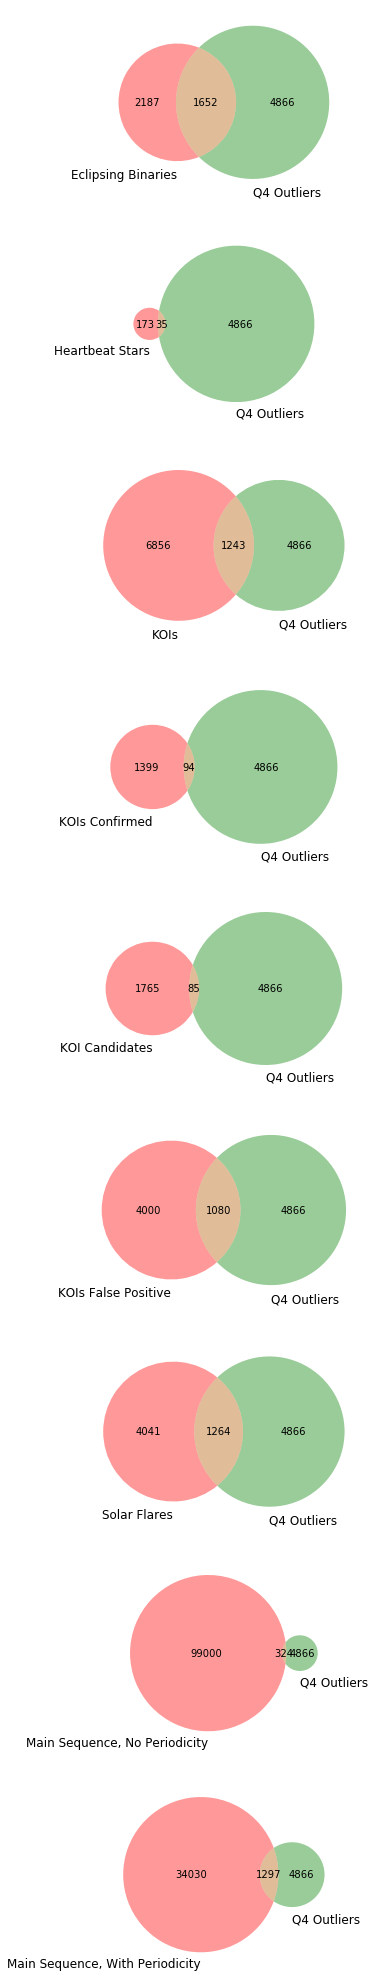

In [669]:
Q = 'Q4'
figure, axes = plt.subplots(len(summary_df.index), 1,figsize=(15,len(summary_df.index)*4))

for i in range(len(summary_df.index)):
    cat = i
    venn2(subsets = (summary_df.ctlg_ct[cat],len(outliers(paper_qs[Q].data)),summary_df['ctlg_U_'+Q+'out'][cat]),
          set_labels=(summary_df.index[cat],Q+' Outliers'),ax=axes[i])

In [753]:
score_df = base_qs['Q4'].data # dataframe containing scores
scores = lambda kics: score_df.loc[kics].dist_score

df = kois_full # dataframe of catalog
kic_list = [i[:13] for i in df.index] # KIC as kplr#########
kois_full_scores = scores(kic_list)

df = kois_confirmed
kic_list = [i[:13] for i in df.index]
kois_confirmed_scores = scores(kic_list)

df = kois_candidate
kic_list = [i[:13] for i in df.index]
kois_candidate_scores = scores(kic_list)

df = kois_fp
kic_list = [i[:13] for i in df.index]
kois_fp_scores = scores(kic_list)

df = ebs
kic_list = [i[:13] for i in df.index]
ebs_scores = scores(kic_list)

with open('list_kepler_heartbeats.txt','r') as file:
    lines = file.readlines()
kic_list = ['kplr'+'0'*(9-len(str(int(line[:8]))))+str(int(line[:8])) for line in lines[37:-2]]
heartbeat_scores = scores(kic_list).dropna()

with open('kepler_solar_flares.txt','r') as file:
    lines = file.readlines()
kic_list = ['kplr'+'0'*(9-len(str(int(line[:8]))))+str(int(line[:8])) for line in lines[22:]] 
flares_scores = scores(kic_list).dropna()

with open('list_kepler_nosig.txt','r') as file:
    lines = file.readlines()
kic_list = ['kplr'+'0'*(9-len(str(int(line[:8]))))+str(int(line[:8])) for line in lines[28:]] 
no_sig_scores = scores(kic_list).dropna()

with open('list_kepler_MSperiods.txt','r') as file:
    lines = file.readlines()
kic_list = ['kplr'+'0'*(9-len(str(int(line[:8]))))+str(int(line[:8])) for line in lines[32:]]  
periodic_scores = scores(kic_list).dropna()

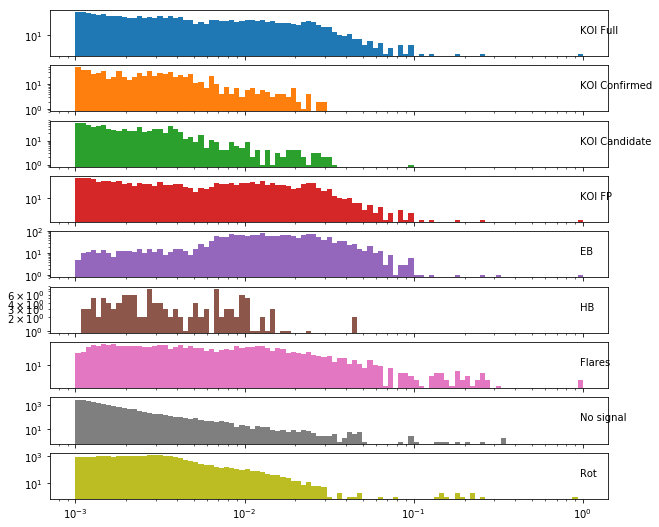

In [755]:
bins = np.logspace(-3,0,100)
plt.figure(figsize=(10,9))
i=0
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'KOI Full'
ax.hist(color=c,x=kois_full_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'KOI Confirmed'
ax.hist(color=c,x=kois_confirmed_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'KOI Candidate'
ax.hist(color=c,x=kois_candidate_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'KOI FP'
ax.hist(color=c,x=kois_fp_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'EB'
ax.hist(color=c,x=ebs_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'HB'
ax.hist(color=c,x=heartbeat_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'Flares'
ax.hist(color=c,x=flares_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'No signal'
ax.hist(color=c,x=no_sig_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'Rot'
ax.hist(color=c,x=periodic_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

In [ ]:
df = base_qs['Q4'].data
object_classes = summary_df.index

plt.figure(figsize=(10,len(object_classes)/2))
i=0
bins = np.logspace(-3,0,100)
for cl in object_classes:
    ax = plt.subplot(len(object_classes),1,i+1)
    c = "C{}".format(i%10)
    sampler = make_sampler[]
    ax.hist(df[df['Debosscher_class']==cl].dist_score,bins=bins,log=True,label=cl,color=c)
    ax.set_xscale('log')
    ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
    i+=1

In [242]:
with open('kepler_variable_classes.txt','r') as file:
    lines = file.readlines()

In [249]:
tmp = np.genfromtxt('kepler_variable_classes.txt',dtype=str,skip_header=50)

In [269]:
tmp[tmp[:,4]=='SR'][:,0]

array(['7451258', '12216195', '4588755', '11129407'], 
      dtype='<U8')

In [267]:
for cl in np.unique(tmp[:,4]):
    print("{}: {}".format(cl,len(tmp[tmp[:,4]==cl])))

ACT: 20862
BCEP: 19187
CLCEP: 21
DSCUT: 1060
ECL: 2544
ELL: 200
GDOR: 488
MISC: 96745
ROT: 8654
RRAB: 6
RRC: 16
RVTAU: 3
SPB: 466
SR: 4


In [271]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adictctlg_U_Q16out

Debosscher_summary = pd.DataFrame()

for cl in np.unique(tmp[:,4]):
    if cl != 'MISC':
        catalog_list = tmp[tmp[:,4]==cl][:,0]
        class_summary=catalog_summary(catalog_list,paper_qs)
        df_tmp = pd.DataFrame(class_summary,index=[cl])
        Debosscher_summary = Debosscher_summary.append(df_tmp)
    

In [382]:
# Run seperately because it contains 96,745 objects
cl='MISC'
catalog_list = tmp[tmp[:,4]==cl][:,0]
class_summary=catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(class_summary,index=[cl])
Debosscher_summary = Debosscher_summary.append(df_tmp)

In [383]:
Debosscher_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
ACT,448,416,268,314,20862
BCEP,181,181,149,153,19187
CLCEP,18,17,18,18,21
DSCUT,150,160,108,104,1060
ECL,1136,1125,1081,1077,2544
ELL,126,118,116,116,200
GDOR,123,122,104,98,488
ROT,1413,1375,1153,1230,8654
RRAB,4,4,4,4,6
RRC,14,14,14,14,16


|Stellar variability class| 	Abbreviation| Count in Debosscher (in common w/ previous paper)*|
|-------------------------|-----------------|--------------------------------------------------|
|β-Cephei stars| 	BCEP| 19,187
|Classical Cepheids |	CLCEP| 21
|Double-mode Cepheids| 	DMCEP| 0
|δ-Scuti stars| 	DSCUT| 1060
|Eclipsing binaries (all types)| 	ECL| 2544
|Ellipsoidal variables| 	ELL| 200
|γ-Doradus stars| 	GDOR| 488
|Mira variables| 	MIRA| 0
|RR-Lyrae stars, subtype ab| 	RRAB| 6
|RR-Lyrae stars, subtype c| 	RRC| 16
|Double-mode RR-Lyrae stars| 	RRD| 0
|RV-Tauri stars| 	RVTAU| 3
|Slowly pulsating B-stars| 	SPB| 466
|Semi-regular variables| 	SR| 4
|Rotational modulation| 	ROT| 8654
|Active stars| 	ACT| 20862
|Miscellaneous| 	MISC| 96745

*Debosscher reports the probability for the top 3 classes for each object. The count here is based on primary identification without consideration of its probability of belonging to that group.



In [ ]:
lines = np.genfromtxt('kepler_variable_classes.txt',dtype=str,skip_header=50)
Debosscher_full_df = pd.DataFrame(data=lines[:,4],columns=["Class"],index=[lines[:,0]])
Debosscher_full_df[:10]

In [697]:
df = base_qs['Q4'].data
obj_class = []
for i in df.index:
    if str(int(i[4:])) in Debosscher_full_df.index:
        obj_class.append(Debosscher_full_df.loc[str(int(i[4:]))].Class)
    else:
        obj_class.append('Undef')

In [701]:
base_qs['Q4'].data['Debosscher_class']=obj_class

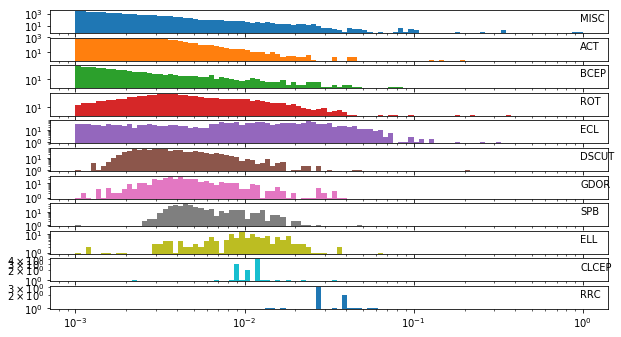

In [702]:
df = base_qs['Q4'].data
object_classes = Debosscher_summary[Debosscher_summary.ctlg_ct>10].sort_values('ctlg_ct',ascending=False).index

plt.figure(figsize=(10,len(object_classes)/2))
i=0
bins = np.logspace(-3,0,100)
for cl in object_classes:
    ax = plt.subplot(len(object_classes),1,i+1)
    c = "C{}".format(i%10)
    ax.hist(df[df['Debosscher_class']==cl].dist_score,bins=bins,log=True,label=cl,color=c)
    ax.set_xscale('log')
    ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
    i+=1


### Simbad

In [ ]:
with open('simbad_bib.txt','r') as file:
    lines = file.readlines()

simbad_type_df = pd.DataFrame(columns=['Class'])
for line in lines:
    if line[:2] == 'KI':
        KIC = line[:-1]
    if line[:2] == 'Ob':
        string = line
        obj_type = string[string.index('---')+5:string.index('  ---  OID')]
        simbad_type_df = simbad_type_df.append(pd.DataFrame({'Class':obj_type},index=[KIC]))

In [319]:
out_paper = np.genfromtxt('outlier_properties.csv',delimiter=',',dtype=str)[:,0]

|Simbad code| 	Description|
|-------------------------|-----------------|
|*| Star (generic)|
|**| Double or multiple star|
|?| Object of unkonwn nature|
|Al*| Eclipsing binary of Algol type|
|BS*| Blue straggler star|
|BY*| Variable of BY Dra type|
|Be*| Be Star|
|C*| Carbon Star|
|CV*| Cataclysmic Variable Star|
|Ce*| Cepheid variable Star|
|DN*| Dwarf Nova|
|EB*| Eclipsing Binary|
|EB?| Eclipsing Binary Candidate|
|El*| Ellipsoidal variable Star|
|Em*| Emission-line Star|
|Er*| Eruptive variable Star|
|G| Galaxy|
|HS*| Hot subdwarf|
|LM*| Low-mass star (M<1M$_\odot$)|
|LP*| Long-period variable star|
|Mi*| Variable Star of Mira Cet type|
|No*| Nova|
|PM*| High proper-motion Star|
|Pe*| Peculiar Star|
|Pu*| Pulsating variable Star|
|RB?| Possible Red Giant Branch star|
|RG*| Red Giant Branch star|
|RR*| Variable Star of RR Lyr type|
|RS*| Variable of RS CVn type|
|RV*| Variable Star of RV Tau type|
|Ro*| Rotationally variable Star|
|S*| S Star|
|SB*| Spectroscopic binary|
|SX*| Variable Star of SX Phe type (subdwarf)|
|Sy1| Seyfert 1 Galaxy|
|V*| Variable Star|
|V*?| Star suspected of Variability|
|WU*| Eclipsing binary of W UMa type|
|a2*| Variable Star of alpha2 CVn type|
|bC*| Variable Star of beta Cep type|
|bL*| Eclipsing binary of beta Lyr type|
|cC*| Classical Cepheid (delta Cep type)|
|dS*| Variable Star of delta Sct type|
|gD*| Variable Star of gamma Dor type|

In [399]:
lines = np.genfromtxt('simbad.csv',delimiter=';',skip_header=7,dtype=str)[:,1:]

simbad_full_df = pd.DataFrame(data=lines[:,1],columns=["Class"],index=[lines[:,0]])

simbad_summary = pd.DataFrame()
for cl in simbad_full_df.Class.unique():
    if cl != '*':
        catalog_list = simbad_full_df[simbad_full_df.Class==cl].index
        class_summary=catalog_summary(catalog_list,paper_qs)
        df_tmp = pd.DataFrame(class_summary,index=[cl])
        simbad_summary = simbad_summary.append(df_tmp)


In [427]:
catalog_list = simbad_full_df[simbad_full_df.Class=='*'].index # ran seperately bc it contains >2/3 of the objects
class_summary=catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(class_summary,index=['*'])
simbad_summary = simbad_summary.append(df_tmp)
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Ce*,28,28,28,28,29
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
RG*,38,41,28,32,3249
EB*,560,551,511,507,1004
PM*,51,46,18,33,1319
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147


In [456]:
simbad_summary[simbad_summary.ctlg_ct>100].sort_values('ctlg_ct',ascending=False)

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
*,879,883,627,685,94309
Ro*,1885,1788,1450,1553,26223
RG*,38,41,28,32,3249
PM*,51,46,18,33,1319
Er*,170,187,122,128,1112
EB*,560,551,511,507,1004
Al*,737,737,732,724,794
dS*,91,93,76,71,463
WU*,407,405,401,396,416
V*,60,58,54,58,264


In [479]:
simbad_classes = simbad_sampler(simbad_full_df)

In [508]:
df = base_qs['Q4'].data
obj_class = []
for i in df.index:
    if i in simbad_full_df.index:
        obj_class.append(simbad_full_df.loc[i].Class)
    else:
        obj_class.append('Undef')

In [516]:
base_qs['Q4'].data['simbad_class'] = obj_class

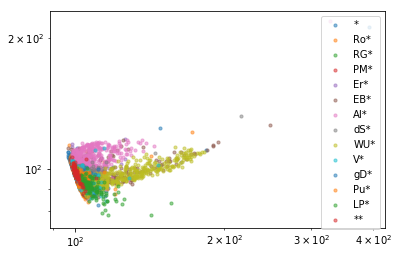

In [563]:
for cl in simbad_summary[simbad_summary.ctlg_ct>100].sort_values('ctlg_ct',ascending=False).index:
    plt.scatter(df[df['simbad_class']==cl].pca_x+100,df[df['simbad_class']==cl].pca_y+100,s=10,alpha=0.5,label=cl)

#plt.scatter(df[df['simbad_class']=='Undef'].pca_x,df[df['simbad_class']=='Undef'].pca_y,s=2,alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [634]:
featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_4" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4_sample = coo(featCSV,fitsDir)

tsne_sample_list = [i[4:13] for i in Q4_sample.data.index]
tsneSampler = make_sampler(tsne_sample_list)
Q4_tsneSampleClasses = tsneSampler(base_qs['Q4'].data).simbad_class

Q4_sample.data['simbad_class']=Q4_tsneSampleClasses.as_matrix()

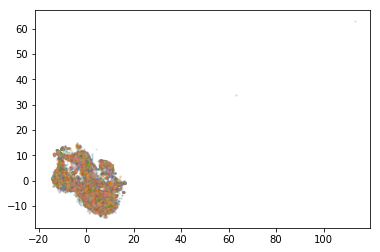

In [640]:
df = Q4_sample.data
for cl in simbad_summary[simbad_summary.ctlg_ct>100].sort_values('ctlg_ct',ascending=False).index:
    plt.scatter(df[df['simbad_class']==cl].tsne_x,df[df['simbad_class']==cl].tsne_y,s=2,alpha=0.2,label=cl)

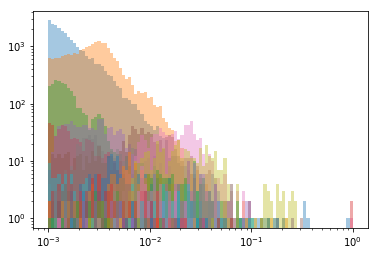

In [543]:
df = base_qs['Q4'].data
bins = np.logspace(-3,0,100)
for cl in simbad_summary.sort_values('ctlg_ct',ascending=False).index:
    plt.hist(df[df['simbad_class']==cl].dist_score,bins=bins,log=True,alpha=0.4,label=cl)
    
plt.xscale('log')
#plt.legend()

/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  --------


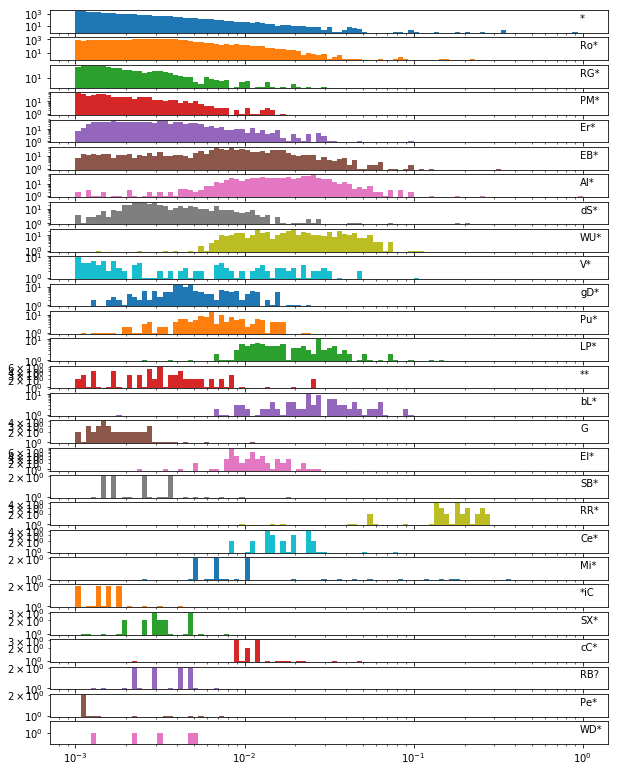

In [645]:
df = base_qs['Q4'].data
object_classes = simbad_summary[simbad_summary.ctlg_ct>10].sort_values('ctlg_ct',ascending=False).index

plt.figure(figsize=(10,len(object_classes)/2))
i=0
bins = np.logspace(-3,0,100)
for cl in object_classes:
    ax = plt.subplot(len(object_classes),1,i+1)
    c = "C{}".format(i%10)
    ax.hist(df[df['simbad_class']==cl].dist_score,bins=bins,log=True,label=cl,color=c)
    ax.set_xscale('log')
    ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
    i+=1


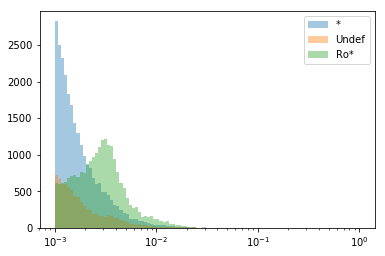

In [542]:
df = base_qs['Q4'].data
bins = np.logspace(-3,0,100)
plt.hist(df[df['simbad_class']=='*'].dist_score,bins=bins,log=False,alpha=0.4,label='*')
plt.hist(df[df['simbad_class']=='Undef'].dist_score,bins=bins,log=False,alpha=0.4,label='Undef')
plt.hist(df[df['simbad_class']=='Ro*'].dist_score,bins=bins,log=False,alpha=0.4,label='Ro*')

plt.xscale('log')
plt.legend()

In [470]:
simbad_sampler = make_sampler(simbad_full_df.index)
simbad_sample = simbad_sampler(base_qs['Q4'].data)

In [484]:
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Ce*,28,28,28,28,29
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
RG*,38,41,28,32,3249
EB*,560,551,511,507,1004
PM*,51,46,18,33,1319
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147


In [485]:
tmp_df = pd.DataFrame({'Mean':[simbad_sample[simbad_classes.Class==c].dist_score.mean() for c in simbad_classes.Class.unique()],
                       'Median':[simbad_sample[simbad_classes.Class==c].dist_score.median() for c in simbad_classes.Class.unique()]
                      },index=simbad_classes.Class.unique())

In [ ]:

for c in simbad_classes.Class.unique():

    subset = simbad_sample[simbad_classes.Class==c]
    mean = subset.dist_score.mean()
    med = subset.dist_score.median()
    simbad
    print("""
Class {}: Number of objects: {}, Mean outlier score: {}, Median outlier score: {}
""".format(c,len(subset),mean,med))

In [489]:
simbad_classes.Q4_mean = tmp_df.Mean

In [492]:
simbad_summary.Q4_mean = tmp_df.Mean

In [498]:
simbad_summary['Q4_median'] = tmp_df.Median

In [756]:
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct,Q4_mean,Q4_median
Ce*,28,28,28,28,29,0.020462,0.016599
Er*,170,187,122,128,1112,0.004166,0.002820
Ro*,1885,1788,1450,1553,26223,0.002968,0.002387
Al*,737,737,732,724,794,0.021043,0.016808
RG*,38,41,28,32,3249,0.001695,0.001344
EB*,560,551,511,507,1004,0.009881,0.006867
PM*,51,46,18,33,1319,0.001440,0.000892
V*,60,58,54,58,264,0.005073,0.001027
dS*,91,93,76,71,463,0.005744,0.003058
Pu*,76,77,61,68,147,0.007226,0.006300


We want to be able to plug in an individual object and retreive information on it including:
* it's scores
  * score for each quarter
  * rank for each quarter
  * score/rank in relation to similar objects (if previously classified)
* any previous classifications
* it's lightcurve

In [1100]:
import quarterTools as qt
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import numpy as np
np.set_printoptions(threshold=np.nan)


catalogs = {'koi_full':['list_koi_full.txt',',',2],
            'koi_confirmed':['list_koi_confirmed.txt',',',2],
            'koi_candidate':['list_koi_candidate.txt',',',2],
            'koi_fp':['list_koi_fp.txt',',',2],
            'EB':['list_EBs.csv',',',0],
            'HB':['list_kepler_heartbeats.txt',None,37],
            'flares':['kepler_solar_flares.txt',None,22],
            'no_signal':['list_kepler_nosig.txt',None,28],
            'periodic':['list_kepler_MSperiods.txt',None,32]}

class weirdnessProfile(object):
    def __init__(self,
                 KIC='8462852',
                 Qs=['Q4','Q8','Q11','Q16'],
                 analysis_path='/home/dgiles/Documents/KeplerLCs/output/Analysis/',
                 fitsDirPath='/home/dgiles/Documents/KeplerLCs/fitsFiles/'):
        if KIC[:3]=='KIC':
            self.KIC = str(int(KIC[3:]))
        elif KIC[:4]=='kplr':
            self.KIC = str(int(KIC[4:]))
        else:
            try:
                self.KIC = str(int(KIC))
            except:
                print("ID not recognized. Try without a prefix?")
        self.Qs = Qs
        self.analysis_path = analysis_path
        self.fitsDirPath = fitsDirPath
        self.sampler = lambda df: df[df.index.str.contains(self.KIC)]
        self.full_analysis_data = {Q:pd.read_csv(self.analysis_path+Q+'_analysis.csv',index_col=0) for Q in self.Qs}
        self.analysis_data = {Q:self.sampler(self.full_analysis_data[Q]) for Q in self.Qs}
        self.scores = self.scoreSummary()
        self.ranks = self.rankSummary()
        self.catalogs,self.ctlg_sampler = self.catalogCheck()
        self.ctlg_summary = self.catalogCompare()
        self.printSummary()
        
    def scoreSummary(self):
        scores = pd.DataFrame()
        for Q in self.Qs:
            dftmp = self.analysis_data[Q].loc[:,['dist_score','PCA90_score','PCA95_score','PCA99_score']]
            dftmp.index = [Q]
            scores = scores.append(dftmp)
        return scores
    
    def rankSummary(self):
        # Returns the percentile of the object in relation to the rest of the quarter's data, generally more illuminating than the score
        full_ranks={}
        for Q in self.Qs:
            full_ranks[Q] = self.full_analysis_data[Q].loc[:,[]]
            full_ranks[Q]['Full'] = self.full_analysis_data[Q].dist_score.rank(ascending=False)
            full_ranks[Q]['Full_pctl'] = self.full_analysis_data[Q].dist_score.rank(ascending=True)/len(self.full_analysis_data[Q])*100
            full_ranks[Q]['PCA90'] = self.full_analysis_data[Q].PCA90_score.rank(ascending=False)
            full_ranks[Q]['PCA90_pctl'] = self.full_analysis_data[Q].PCA90_score.rank(ascending=True)/len(self.full_analysis_data[Q])*100
            full_ranks[Q]['PCA95'] = self.full_analysis_data[Q].PCA95_score.rank(ascending=False)
            full_ranks[Q]['PCA95_pctl'] = self.full_analysis_data[Q].PCA95_score.rank(ascending=True)/len(self.full_analysis_data[Q])*100
            full_ranks[Q]['PCA99'] = self.full_analysis_data[Q].PCA99_score.rank(ascending=False)
            full_ranks[Q]['PCA99_pctl'] = self.full_analysis_data[Q].PCA99_score.rank(ascending=True)/len(self.full_analysis_data[Q])*100
        self.full_ranks = full_ranks
        
        ranks = pd.DataFrame()
        for Q in self.Qs:
            dftmp = self.sampler(full_ranks[Q])
            dftmp.index = [Q]
            ranks = ranks.append(dftmp)
            
        return ranks
    
    def plotlcs(self):
        for Q in self.Qs:
            qt.plot_lc(self.analysis_data[Q].index[0],self.fitsDirPath+Q+'fitsfiles/')
        return
    
    def pcaPlots(self):
        # Plots each quarter's data into the top 2 principle components from a PCA reduction
        for Q in self.Qs:
            x = self.full_analysis_data[Q].pca_x
            y = self.full_analysis_data[Q].pca_y
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
            ax.scatter(x,y)
            ax.scatter(self.analysis_data[Q].pca_x,self.analysis_data[Q].pca_y)
            
    def catalogCheck(self):
        # Checks the available catalogs to see if the object is contained in them
        in_catalogs = []
        ctlg_sampler = {}
        # Catalogs of individual classes are looped through here
        for ctlg in catalogs:
            import_ref = catalogs[ctlg]
            ctlg_list = np.genfromtxt(import_ref[0],delimiter=import_ref[1],skip_header=import_ref[2],usecols=(0),dtype=str)
            if self.KIC in ctlg_list:
                in_catalogs.append(ctlg)
                ctlg_sampler[ctlg] = qt.make_sampler(ctlg_list)
                
        # Debosscher and SIMBAD have a bunch of different classifications, each need parsed out
        lines = np.genfromtxt('kepler_variable_classes.txt',dtype=str,skip_header=50)
        Debosscher_full_df = pd.DataFrame(data=lines[:,4],columns=["Class"],index=lines[:,0])
        if Debosscher_full_df.index.str.contains(self.KIC).any():
            deb_class = Debosscher_full_df.loc[self.KIC,'Class']
            ctlg_sampler['Deb_Class_%s'%deb_class]=qt.make_sampler(Debosscher_full_df[Debosscher_full_df.Class==deb_class].index)
            in_catalogs.append('Deb_Class_%s'%deb_class)
            
        lines = np.genfromtxt('simbad.csv',delimiter=';',skip_header=7,dtype=str)[:,1:]
        simbad_full_df = pd.DataFrame(data=lines[:,1],columns=["Class"],index=lines[:,0])
        if simbad_full_df.index.str.contains(self.KIC).any():
            sim_class = simbad_full_df.loc[simbad_full_df.index.str.contains(self.KIC),'Class'][0]
            ctlg_sampler['SIMBAD_Class_%s'%sim_class]=qt.make_sampler(simbad_full_df[simbad_full_df.Class == sim_class].index)
            in_catalogs.append('SIMBAD_Class_%s'%sim_class)
            
        return in_catalogs,ctlg_sampler
    
    def catalogCompare(self):
        # Produces summary dataframes for each catalog the object belongs to, 
        # the summary includes the mean score and the standard deviation of the scores of the catalog
        catalog_data_summary = {}
        for ctlg in self.catalogs:
            catalog_data_summary[ctlg] = pd.DataFrame()
            for Q in self.Qs:
                path = self.analysis_path+Q+'_'+ctlg+'_analysis.csv'
                ctlg_data = pd.read_csv(path,index_col=0)
                tmp_df = pd.DataFrame({'dist_score':ctlg_data.dist_score.mean(),
                                       'dist_std':ctlg_data.dist_score.std(),
                                       'PCA90_score':ctlg_data.PCA90_score.mean(),
                                       'PCA90_std':ctlg_data.PCA90_score.std(),
                                       'PCA95_score':ctlg_data.PCA95_score.mean(),
                                       'PCA95_std':ctlg_data.PCA95_score.std(),
                                       'PCA99_score':ctlg_data.PCA99_score.mean(),
                                       'PCA99_std':ctlg_data.PCA99_score.std()},
                                      index=[Q])
                catalog_data_summary[ctlg] = catalog_data_summary[ctlg].append(tmp_df)
        return catalog_data_summary
    def ctlgCmpViz(self,ctlg,scoreType='dist'):
        # Plots the score of the object against the score of the catalog with errorbars
        qs = [int(i[1:]) for i in self.scores.index]
        plt.scatter(qs,self.scores.loc[:,scoreType+'_score'])
        plt.scatter(qs,self.ctlg_summary[ctlg].loc[:,scoreType+'_score'])
        plt.errorbar(qs,self.ctlg_summary[ctlg].loc[:,scoreType+'_score'],self.ctlg_summary[ctlg].loc[:,scoreType+'_std'])
        
    def printSummary(self):
        # Prints out the scores for the object in each given quarter, the catalogs it's contained in, 
        # and any significant score deviations from its identified catalogs
        print("Scores of KIC {}".format(self.KIC))
        display(self.scores)
        display(self.ranks)
        print("KIC{} contained in these catalogs: {}".format(self.KIC,self.ctlg_summary.keys()))
        for k in self.ctlg_summary.keys():
            for Q in self.Qs:
                if abs(self.ctlg_summary[k].loc[Q,'dist_score']-self.scores.loc[Q,'dist_score'])>self.ctlg_summary[k].loc[Q,'dist_std']:
                    print("Significant deviation (>1 sigma) from {} catalog in Quarter {}".format(k,Q))

['Deb_Class_ACT', 'SIMBAD_Class_*']


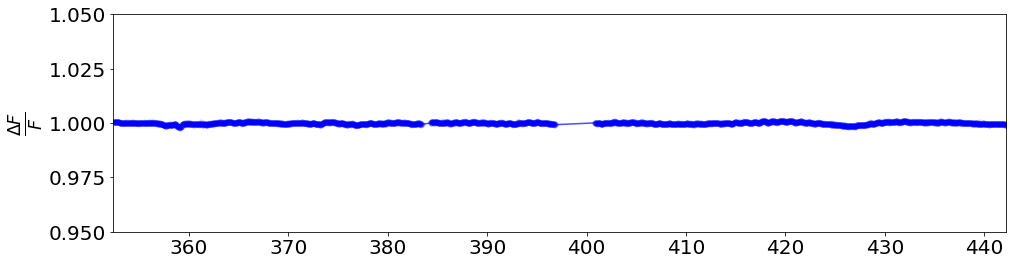

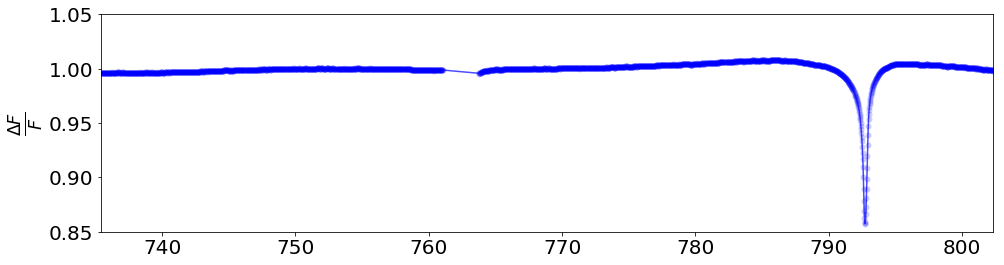

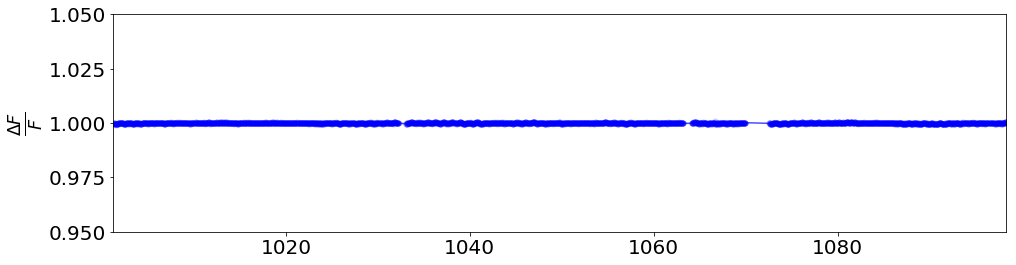

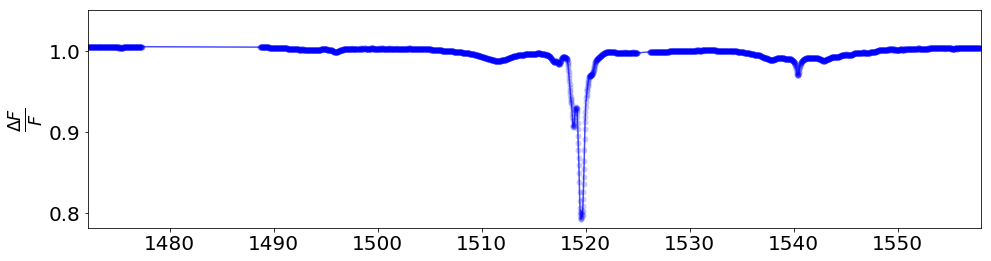

In [1103]:
kic = '8462852'
kic_profile = weirdnessProfile(kic)
print(kic_profile.catalogs)
kic_profile.plotlcs()

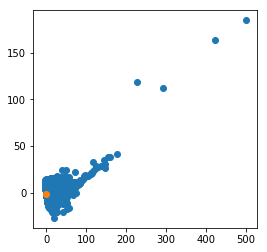

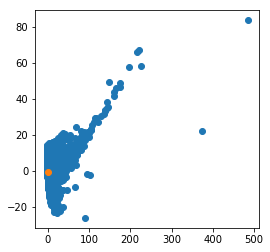

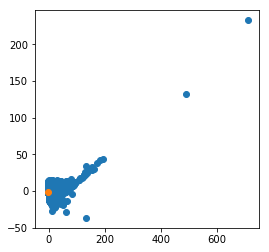

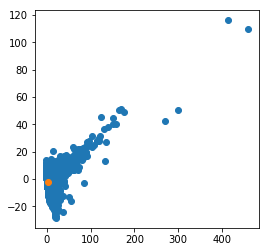

In [1104]:
kic_profile.pcaPlots() #pca plots aren't super amazing at illustrating the outlying nature of things, but it's quick

In [1098]:
from IPython.display import display
print(kic_profile.KIC+" Score Summary")
display(kic_profile.scores)
for k in kic_profile.ctlg_summary.keys():
    print(k+" Score Summary")
    display(kic_profile.ctlg_summary[k])

5438845 Score Summary


,dist_score,PCA90_score,PCA95_score,PCA99_score
Q4,0.026553,0.015014,0.033022,0.061198
Q8,0.000410,0.000454,0.000716,0.000792
Q11,0.015988,0.017295,0.031717,0.045048
Q16,0.031773,0.024410,0.064065,0.073206


no_signal Score Summary


,PCA90_score,PCA95_score,PCA99_score,dist_score
Q4,0.000793,0.001080,0.001546,0.000840
Q8,0.000971,0.001222,0.001649,0.000739
Q11,0.000819,0.001136,0.001514,0.000555
Q16,0.000771,0.001075,0.001562,0.000780


Deb_Class_ACT Score Summary


,PCA90_score,PCA95_score,PCA99_score,dist_score
Q4,0.001941,0.002630,0.004112,0.002198
Q8,0.002409,0.003284,0.004329,0.001940
Q11,0.002030,0.002895,0.004004,0.001452
Q16,0.001871,0.002694,0.003991,0.001975


SIMBAD_Class_* Score Summary


,PCA90_score,PCA95_score,PCA99_score,dist_score
Q4,0.000957,0.001302,0.001889,0.001027
Q8,0.001169,0.001505,0.002024,0.000905
Q11,0.000980,0.001371,0.001853,0.000675
Q16,0.000970,0.001341,0.001932,0.000978


In [963]:
"""
# CSVs for individual catalog analysis produced. Personal note: probably a waste of HD space, 
# but it's so much quicker to reference existing CSVs then to reanalyze huge subsets.

for ctlg in catalogs:
    import_ref = catalogs[ctlg]
    ctlg_list = np.genfromtxt(import_ref[0],delimiter=import_ref[1],skip_header=import_ref[2],usecols=(0),dtype=str)
    ctlg_sampler[ctlg] = make_sampler(ctlg_list)
    for Q in Qs:
        ctlg_analysis_data = ctlg_sampler[ctlg](tabby.full_analysis_data[Q])
        ctlg_analysis_data.to_csv('/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_'+ctlg+'_analysis.csv')
for cl in Debosscher_full_df.Class.unique():
    ctlg = 'Deb_Class_%s'%cl
    ctlg_sampler[ctlg]=make_sampler(Debosscher_full_df[Debosscher_full_df.Class == cl].index)
    print("Debosscher Class %s"%cl)
    for Q in Qs:
        print("Quarter %s"%Q)
        ctlg_analysis_data = ctlg_sampler[ctlg](tabby.full_analysis_data[Q])
        ctlg_analysis_data.to_csv('/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_'+ctlg+'_analysis.csv')

for cl in simbad_full_df.Class.unique():
    ctlg = 'SIMBAD_Class_%s'%cl
    ctlg_sampler[ctlg]=make_sampler(simbad_full_df[simbad_full_df.Class == cl].index)
    print("Simbad Class %s"%cl)
    for Q in Qs:
        print("Quarter %s"%Q)
        ctlg_analysis_data = ctlg_sampler[ctlg](tabby.full_analysis_data[Q])
        ctlg_analysis_data.to_csv('/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_'+ctlg+'_analysis.csv')
"""

Catalogs import information

|Catalog|Delimiter|Header Length|
|-------|---------|-------------|
|list_koi_full.txt|','|2|
|list_koi_confirmed.txt|','|2|
|list_koi_candidate.txt|','|2|
|list_koi_fp.txt|','|2|
|list_EBs.csv|','|0|
|list_kepler_heartbeats.txt|None|37|
|kepler_solar_flares.txt|None|22|
|list_kepler_nosig.txt|None|28|
|list_kepler_MSperiods.txt|None|32|



In [800]:
catalogs = {'koi_full':['list_koi_full.txt',',',2],
            'koi_confirmed':['list_koi_confirmed.txt',',',2],
            'koi_candidate':['list_koi_candidate.txt',',',2],
            'koi_fp':['list_koi_fp.txt',',',2],
            'EB':['list_EBs.csv',',',0],
            'HB':['list_kepler_heartbeats.txt',None,37],
            'flares':['kepler_solar_flares.txt',None,22],
            'no_signal':['list_kepler_nosig.txt',None,28],
            'periodic':['list_kepler_MSperiods.txt',None,32]}

In [1107]:
simbad_full_df[:3]

,Class
KID,
kplr000757076,*
kplr000757099,Ce*
kplr000757137,Er*


In [7]:
import pickle
path_to_output = '../KeplerLCs/output/'
Q_dict = dict()
for i in range(1,18):
    with open(path_to_output+'Q{}.coo'.format(i),'rb') as file:
        Q_dict['Q{}'.format(i)]=pickle.load(file)

In [99]:
import pickle
with open('./scores/Average','rb') as file:
    scores_average = pickle.load(file)
scores_average.describe()

,KIC,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
count,2.012660e+05,156126.000000,166279.000000,165531.000000,169817.000000,166268.000000,165283.000000,163305.000000,167783.000000,167243.000000,166897.000000,164065.000000,166867.000000,166631.000000,166910.000000,164737.000000,167508.000000,167575.000000
mean,8.545279e+06,0.001478,0.001238,0.000835,0.000712,0.000957,0.000498,0.000484,0.000655,0.000734,0.001008,0.000582,0.000880,0.001166,0.001226,0.000918,0.000784,0.000619
std,8.373807e+06,0.004587,0.004973,0.003609,0.003787,0.003745,0.003134,0.002976,0.003146,0.003950,0.004582,0.003298,0.004428,0.005085,0.005554,0.004784,0.003805,0.002799
min,7.570760e+05,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.732821e+06,0.000599,0.000429,0.000279,0.000227,0.000295,0.000177,0.000164,0.000234,0.000231,0.000348,0.000205,0.000297,0.000380,0.000409,0.000305,0.000267,0.000295
50%,8.110344e+06,0.000881,0.000663,0.000433,0.000361,0.000465,0.000271,0.000257,0.000352,0.000362,0.000527,0.000310,0.000457,0.000578,0.000637,0.000472,0.000403,0.000419
75%,1.002978e+07,0.001456,0.001151,0.000773,0.000662,0.000883,0.000485,0.000481,0.000613,0.000693,0.000927,0.000562,0.000806,0.001062,0.001128,0.000852,0.000721,0.000648
max,1.000043e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
import matplotlib.pyplot as plt

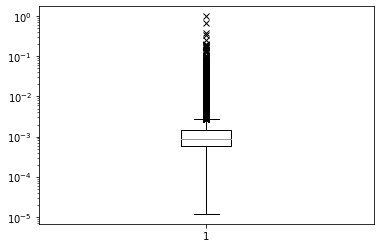

In [49]:
Q1bp = plt.boxplot(scores_average.Q1.dropna(),flierprops=dict(marker='x'))
plt.yscale('log')

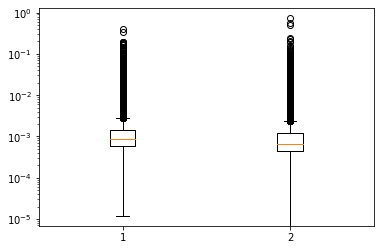

In [24]:
plt.boxplot([scores_average.Q1.dropna(),scores_average.Q2.dropna()])
plt.yscale('log')

In [51]:
scores_average.Q1.dropna()

0         0.001227
1         0.005940
2         0.001092
3         0.001658
4         0.006019
            ...   
198955    0.000775
198956    0.002093
198957    0.001298
198958    0.001610
198959    0.002531
Name: Q1, Length: 156126, dtype: float64

In [72]:
lines = np.genfromtxt('debosscher_classes.txt',dtype=str,skip_header=49)

In [73]:
lines[0]

array(['2303694', '1.00', '0.00', '0.00', 'MISC', 'BCEP', 'ECL'],
      dtype='<U8')

In [99]:
Debosscher_full_df = pd.DataFrame(data=lines[:,1:],columns=['Prob1','Prob2','Prob3','Class1','Class2','Class3'],index=lines[:,0].astype(np.int))
Debosscher_full_df[:10]

,Prob1,Prob2,Prob3,Class1,Class2,Class3
2303694,1.00,0.00,0.00,MISC,BCEP,ECL
3935492,0.86,0.14,0.00,MISC,BCEP,ECL
7533643,0.96,0.02,0.02,ROT,MISC,ACT
3230719,0.99,0.01,0.00,MISC,ECL,ACT
6047853,1.00,0.00,0.00,MISC,ECL,RRD
9419545,1.00,0.00,0.00,MISC,ACT,ECL
4902107,0.72,0.27,0.02,MISC,ROT,ACT
8571870,0.75,0.25,0.00,MISC,BCEP,ECL
11295149,1.00,0.00,0.00,MISC,ECL,RRD
4919193,0.79,0.21,0.00,MISC,ACT,ECL


In [100]:
Debosscher_full_df.sort_index()

,Prob1,Prob2,Prob3,Class1,Class2,Class3
757076,1.00,0.00,0.00,BCEP,MISC,ECL
757099,0.95,0.03,0.01,BCEP,MISC,RRC
757137,1.00,0.00,0.00,MISC,ECL,RRD
757280,1.00,0.00,0.00,MISC,ECL,RRD
757450,1.00,0.00,0.00,ROT,MISC,ECL
...,...,...,...,...,...,...
12984200,0.66,0.34,0.00,MISC,BCEP,ECL
12984214,0.86,0.07,0.07,MISC,ROT,ACT
12984227,1.00,0.00,0.00,ROT,MISC,ECL
12984307,0.98,0.02,0.00,MISC,BCEP,ECL


In [107]:
scores_average.set_index('KIC',inplace=True)

In [111]:
Debosscher_full_df.index

Int64Index([ 2303694,  3935492,  7533643,  3230719,  6047853,  9419545,
             4902107,  8571870, 11295149,  4919193,
            ...
             5022858,  7610378,  5395842,  3336434,  8008913,  3556503,
            11653381, 11618494,  8907195, 12156918],
           dtype='int64', length=150256)

In [121]:
scores_average.loc[Debosscher_full_df.index[:10],:]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
2303694,0.000765,0.000489,0.000453,0.000207,0.000470,0.000201,0.000192,0.000084,0.000135,0.000178,0.000207,0.000201,0.000427,0.000210,0.000790,0.000183,0.000415
3935492,0.000592,0.000169,0.000121,0.000184,0.000167,0.000106,0.000194,0.000241,0.000198,0.000503,0.000236,0.000535,0.000249,0.000444,0.000360,0.000431,0.000280
7533643,0.001486,0.001250,0.001081,0.000804,0.001191,0.000601,0.000503,0.001169,0.001094,0.001330,0.000689,0.001348,0.001935,0.001332,0.000978,0.001051,0.000857
3230719,0.001559,0.001238,0.000494,0.000556,0.000822,0.000316,0.000504,0.000374,0.000472,0.000947,0.000421,0.000790,0.000950,0.000742,0.000755,NaN,NaN
6047853,0.000402,0.000763,0.000387,0.000577,0.000463,0.000284,0.000223,0.000216,0.000246,0.000397,0.000205,0.000387,0.000600,0.000437,0.000441,0.000795,0.000270
9419545,0.001163,0.000509,0.000610,0.001143,0.001377,0.000469,NaN,0.000297,0.000354,0.000305,NaN,0.000675,0.000728,0.000547,NaN,0.000406,0.000745
4902107,0.001706,0.001675,0.001430,0.000821,NaN,0.000748,0.000661,0.001588,NaN,0.001129,0.000845,0.001049,NaN,0.001554,0.001706,0.001173,NaN
8571870,0.001025,0.000605,0.000294,0.000334,0.000560,0.000251,0.000197,0.000259,0.000174,0.000360,0.000314,0.000301,0.000221,0.002501,0.000422,0.000249,0.000190
11295149,0.000420,0.000374,0.000267,0.000216,0.000764,0.000241,0.000125,0.000176,0.000378,0.000275,0.000114,0.000339,0.000759,0.000473,0.000346,0.000207,0.000405
4919193,0.001059,0.000827,0.000652,0.000425,NaN,0.000568,NaN,NaN,NaN,0.000741,0.000615,NaN,NaN,0.000757,NaN,NaN,NaN


In [122]:
#fig,ax = plt.subplots(1,len(Debosscher_full_df.Class1.unique()))
scores = dict()
for cl in Debosscher_full_df.Class1.unique():
    scores[cl]=scores_average.loc[Debosscher_full_df[Debosscher_full_df.Class1==cl].index,:]

In [105]:
for cl in Debosscher_full_df.Class1.unique():
    print("Class: {}, Count: {}".format(cl,len(Debosscher_full_df[Debosscher_full_df.Class1==cl])))

Class: MISC, Count: 96745
Class: ROT, Count: 8654
Class: BCEP, Count: 19187
Class: ACT, Count: 20862
Class: ECL, Count: 2544
Class: DSCUT, Count: 1060
Class: GDOR, Count: 488
Class: ELL, Count: 200
Class: SPB, Count: 466
Class: CLCEP, Count: 21
Class: RRAB, Count: 6
Class: RVTAU, Count: 3
Class: RRC, Count: 16
Class: SR, Count: 4


/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  if __name__ == '__main__':


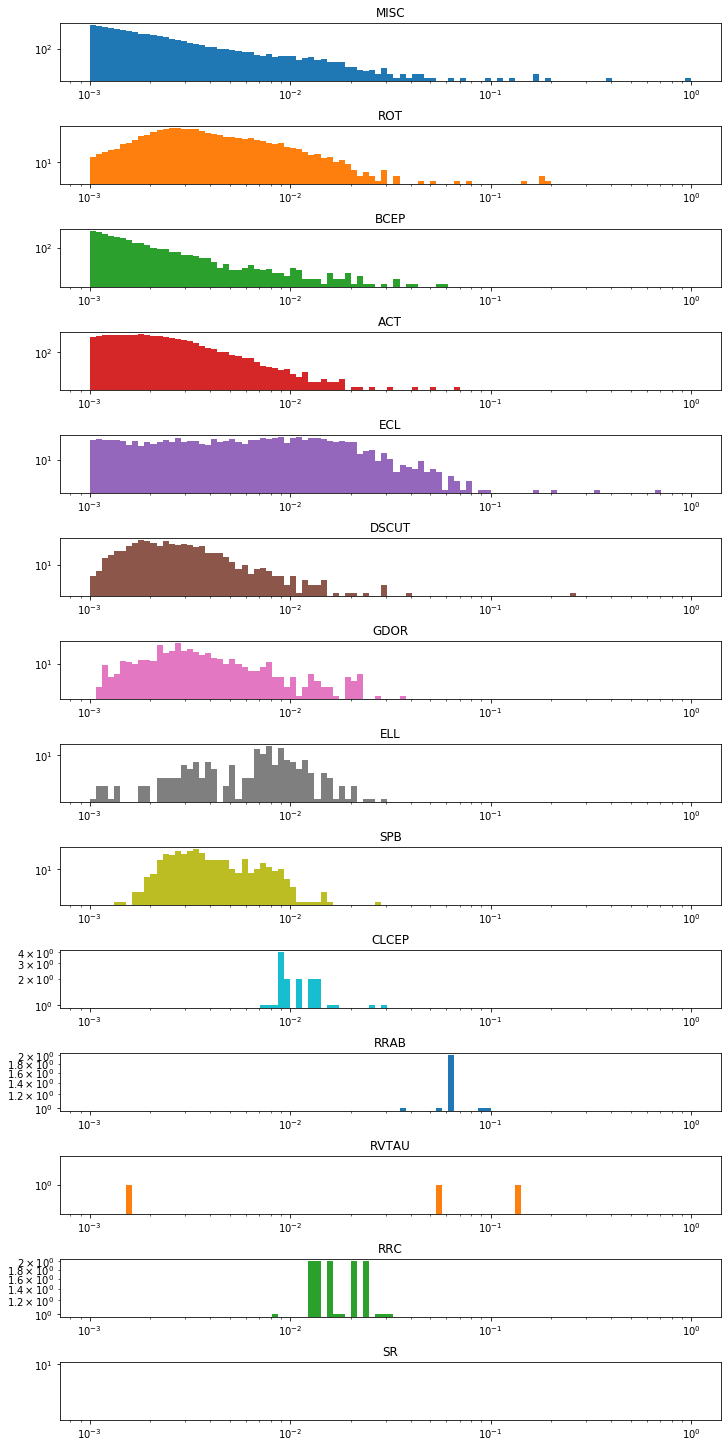

In [148]:
Q='Q1'
bins = np.logspace(-3,0,100)
fig,ax = plt.subplots(len(Debosscher_full_df.Class1.unique()),1,figsize=(10,20),constrained_layout=True)
for i,cl in enumerate(Debosscher_full_df.Class1.unique()):
    c = "C{}".format(i%10)
    ax[i].hist(scores[cl][Q],bins=bins,label=cl,color=c)
    ax[i].set_title(cl)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

In [1]:
from astropy.io import votable

In [15]:
simbad = votable.parse_single_table("simbad.xml",invalid='mask')

# SIMBAD Classes (full KIC)

In [232]:
import numpy as np
import pandas as pd
import pickle

In [37]:
simbad_at = simbad.to_table() # xml to astropy table

In [242]:
simbad_classes = simbad_at['TYPED_ID','OTYPE_S','V__vartyp','V__bibcode'] # only want a class columns
simbad_classes['TYPED_ID']=[int(i[4:]) for i in simbad_classes['TYPED_ID']] # id's to ints
simbad_classes = simbad_classes.to_pandas(index='TYPED_ID') # astropy table to pandas df

In [313]:
# importing scores
with open('./scores/Average','rb') as file:
    scores_average = pickle.load(file)
scores_average.set_index('KIC',inplace=True)
scores_average.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
count,156126.000000,166279.000000,165531.000000,169817.000000,166268.000000,165283.000000,163305.000000,167783.000000,167243.000000,166897.000000,164065.000000,166867.000000,166631.000000,166910.000000,164737.000000,167508.000000,167575.000000
mean,0.001478,0.001238,0.000835,0.000712,0.000957,0.000498,0.000484,0.000655,0.000734,0.001008,0.000582,0.000880,0.001166,0.001226,0.000918,0.000784,0.000619
std,0.004587,0.004973,0.003609,0.003787,0.003745,0.003134,0.002976,0.003146,0.003950,0.004582,0.003298,0.004428,0.005085,0.005554,0.004784,0.003805,0.002799
min,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000599,0.000429,0.000279,0.000227,0.000295,0.000177,0.000164,0.000234,0.000231,0.000348,0.000205,0.000297,0.000380,0.000409,0.000305,0.000267,0.000295
50%,0.000881,0.000663,0.000433,0.000361,0.000465,0.000271,0.000257,0.000352,0.000362,0.000527,0.000310,0.000457,0.000578,0.000637,0.000472,0.000403,0.000419
75%,0.001456,0.001151,0.000773,0.000662,0.000883,0.000485,0.000481,0.000613,0.000693,0.000927,0.000562,0.000806,0.001062,0.001128,0.000852,0.000721,0.000648
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [187]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

In [302]:
def pop_subset(db,kw='OTYPE_S',pop_threshold=1000):
    """
    Purpose:
        Returns id's (as a numpy array of ints) of objects in classes 
        smaller than a given threshold.
    Args:
        db (pands dataframe) - database of objects w/ classifications
            db index must be identifying integers (i.e. for 
            'KIC 8462852' the index must be 8462852)
        kw (str) - keyword, column name in db specifying classes
        pop_threshold (int) - class population threshold, 
            objects w/ less than the threshold are returned
    Returns:
        subset (np.array(dtype=np.int)) - numpy array of indices for the subset
    """
    class_counts = pd.DataFrame(data={'Class':np.unique(db[kw])})
    class_counts['Count'] = [len(db[db[kw]==cls]) for cls in np.unique(db[kw])]
    subset = np.array([],dtype=np.int)
    for cls in class_counts[class_counts['Count']<pop_threshold]['Class']:
        subset = np.append(subset,np.array(db[db[kw]==cls].index,dtype=np.int))
        
    return subset


In [350]:
import os
scores_list = os.listdir('./scores/')

In [356]:
scores_list

['s5',
 'PCA99_sAverage',
 's4',
 'Unreducedref',
 'PCA90_Average',
 'PCA99_Average',
 'PCA99ref',
 '9',
 'PCA95_sAverage',
 '11',
 '7',
 'sAverage',
 's10',
 '6',
 '10',
 '8',
 's11',
 's8',
 's6',
 's7',
 's9',
 'PCA95_Average',
 'PCA90_sAverage',
 'PCA95ref',
 's13',
 '4',
 '12',
 'Average',
 's12',
 '13',
 '5',
 'PCA90ref']

In [327]:
# User defined
# importing scores
with open('./scores/Average','rb') as file:
    scores_average = pickle.load(file)
scores_average.set_index('KIC',inplace=True)

In [357]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for sf in scores_list:
    
    with open('./scores/{}'.format(sf),'rb') as file:
        scores_average = pickle.load(file)
    scores_average.set_index('KIC',inplace=True)

    Q='Q1'
    scoresdf = scores_average
    classesdf = simbad_classes
    kw = 'OTYPE_S'
    th = 1000

    variables = pop_subset(classesdf,kw,th)
    subset = pd.DataFrame(index=scoresdf.index,data={'subset':np.zeros_like(scoresdf.index)})
    subset.loc[variables,'subset'] = 1

    Q_inds = scoresdf[Q].dropna().index
    fpr[sf],tpr[sf],_ = roc_curve(subset.loc[Q_inds,'subset'],scoresdf.loc[Q_inds,Q])
    roc_auc[sf] = auc(fpr[sf],tpr[sf])
#print(roc_auc)
#plt.scatter(fpr,tpr)

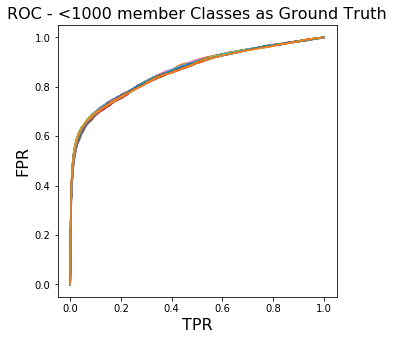

In [362]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
for sid in scores_list:
    ax.plot(fpr[sid],tpr[sid],label="{} (auc={:.3})".format(sid,roc_auc[sid]))
ax.set_ylabel("FPR",fontsize=16)
ax.set_xlabel("TPR",fontsize=16)
#ax.legend()
plt.title("ROC - <1000 member Classes as Ground Truth",fontsize=16)
plt.show()

In [364]:
Q_scores = dict()
for sf in scores_list:
    
    with open('./scores/{}'.format(sf),'rb') as file:
        scores_average = pickle.load(file)
    scores_average.set_index('KIC',inplace=True)
    Q='Q1'
    scoresdf = scores_average
    #classesdf = simbad_classes
    #kw = 'OTYPE_S'
    #th = 1000

    #variables = pop_subset(classesdf,kw,th)
    Q_inds = scoresdf[Q].dropna().index
    Q_scores[sf] = scoresdf.loc[Q_inds,Q]


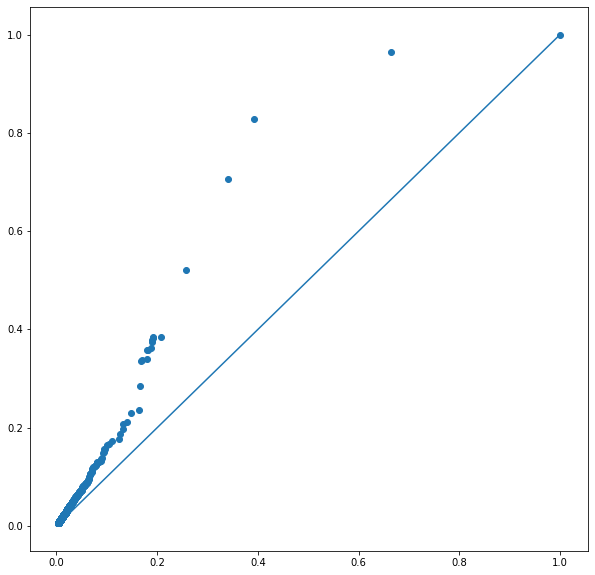

In [377]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(Q_scores['Average'].sort_values(ascending=False).head(10000),
            Q_scores['PCA95_Average'].sort_values(ascending=False).head(10000))
ax.plot([0,1],[0,1])

In [363]:
scores_list

['s5',
 'PCA99_sAverage',
 's4',
 'Unreducedref',
 'PCA90_Average',
 'PCA99_Average',
 'PCA99ref',
 '9',
 'PCA95_sAverage',
 '11',
 '7',
 'sAverage',
 's10',
 '6',
 '10',
 '8',
 's11',
 's8',
 's6',
 's7',
 's9',
 'PCA95_Average',
 'PCA90_sAverage',
 'PCA95ref',
 's13',
 '4',
 '12',
 'Average',
 's12',
 '13',
 '5',
 'PCA90ref']

In [318]:
for th in [2000,1000,500,250,100]:
    variables = pop_subset(simbad_classes,pop_threshold=th)
    scores_average['simbad_variable'] = np.zeros_like(scores_average['Q1'])
    scores_average.loc[variables,'simbad_variable'] = 1
    Q1_inds = scores_average.Q1.dropna().index
    fpr,tpr,_ = roc_curve(scores_average.loc[Q1_inds].simbad_variable,scores_average.loc[Q1_inds].Q1)
    roc_auc = auc(fpr,tpr)
    print("AUC for {}: {}".format(th,roc_auc))



AUC for 5000: 0.7903418478878154
AUC for 2000: 0.7903418478878154
AUC for 1000: 0.8629584834829124
AUC for 500: 0.8125796789399635
AUC for 250: 0.8243355552410455
AUC for 100: 0.797961416678566
